# Reflections on SXSW

A review of Apple's marketing and branding strategies at this year's South by Southwest Conference, to help the Apple marketing team plan next year's South by Southwest campaign.

## 0. Goals of the Analysis

To provide an overview of the brand's perception at this year's conference: what did people like, dislike and discuss the most? How was Apple perceived relative to its competitors?

- Build a classifier to "score" tweets as most negative, most positive and most neutral
- Determine the most negative and most positive SXSW tweets concerning Apple and its products
- Summarize the topics discussed in negative, neutral and positive tweets regarding Apple & its products


Ultimately, we hope to provide concrete recommendations for next year's SXSW brand & marketing strategy based on what was successful this year.

## Environment Set Up

Install xgboost and gensim, and download stopwords from nltk.

In [1]:
%pip install xgboost

%pip install gensim

%pip install pyLDAvis

import nltk
nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Make a list of package versions used in this environment.

In [2]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import pyLDAvis
import gensim
import xgboost
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

nltk==3.8.1
sklearn==1.2.2
pandas==2.0.1
numpy==1.24.3
seaborn==0.12.2
pyLDAvis==3.4.0
gensim==4.3.1
xgboost==1.7.5


Set a seed for random state.

In [3]:
seed = 8945593

Import specific packages needed from various libraries.

In [4]:
# general preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# text-specific preprocessing
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# analysis
from nltk.probability import FreqDist
# topic modeling
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim

## 1. Data Understanding
### 1.1 Part 1

[Data Source](https://data.world/crowdflower/brands-and-product-emotions)

The data was downloaded from the above link on April 21, 2023 and has been stored in .csv format in the below referenced S3 bucket.

In [5]:
# load data

read_bucket = "twitter-sxsw"
file_name = "judge-1377884607_tweet_product_company.csv"

data_uri = f"s3://{read_bucket}/{file_name}"
data = pd.read_csv(data_uri, encoding='latin-1')
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


The "emotion_in_tweet_is_directed_at" category indicates the specific product at which the sentiment in the tweet is directed, if possible. For ease of analysis, we will add a column titled "brand" which simply indicates whether the object of the sentiment is "Apple", "Google", "Android" (or None), so that we can explore the distribution of tweet sentiment by brand.

We'll also rename the columns so that actions require less typing.

In [6]:
# change column names for ease of use
data.rename({'emotion_in_tweet_is_directed_at': 'object',
             'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, axis=1, inplace=True)

# add column (brand)
apple_categories = ['iPad', 'Apple', 'iPad or iPhone App', 'iPhone',
                    'Other Apple product or service']

android_categories = ['Android App', 'Android']

google_categories = ['Google', 'Other Google product or service']

brand_names = dict(zip(apple_categories, ['Apple']*len(apple_categories)))
brand_names.update(dict(zip(android_categories, ['Android']*len(android_categories))))
brand_names.update(dict(zip(google_categories, ['Google']*len(google_categories))))

data['brand'] = data.object.replace(brand_names)

data.head()

,tweet_text,object,sentiment,brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google


#### Summary

- How many tweets are in the dataset overall?

&nbsp;

<center><b>9093 tweets</b></center>

- What is the distribution of the sentiment category?

| Sentiment | % of Data |
| --- | --- |
| Neutral | 59% |
| Positive | 33% |
| Negative | 6% |
| Null | 2% |

- How many null values are we dealing with for the object of the sentiment?

<center><b>357 tweets</b> are labeled as having a positive or negative emotion, but do not indicate the object of the sentiment in the tweet.</center>

&nbsp;

- Out of tweets for which the object of the sentiment is labeled, how many have sentiment directed toward ...

    - Apple? &nbsp;&nbsp; **2337 positive and negative tweets**
    - Google? &nbsp;&nbsp; **697 positive and negative tweets**
    - Android? &nbsp;&nbsp; **157 positive and negative tweets**
    
&nbsp;

- What is the distribution of sentiment for each brand?

<center><u>Apple and Google</u></center>
<center>~17% negative and ~83% positive</center>

&nbsp;

<center><u>Android</u></center>
<center>~10% negative and ~90% positive</center>

- What is the average length of a tweet in this dataset (in words)?

<center>The mean length of a tweet in this dataset is <b>18 words</b>. The shortest tweet contains only 2 words; the longest tweet contains 33 words.</center>

**Visualizations**

Below, graphs are generated to show the count of positive and negative tweets directed toward each brand.

Tweets with "no emotion" or ambiguous emotion ("I can't tell") are not included as most neutral tweets do not specify a brand.

In [7]:
sentiment_counts_by_brand = data.loc[~data.object.isna()].groupby(['brand', 'sentiment'])['tweet_text'].count()

Set style of plots to use throughout notebook.

*Note: The style is meant to emulate the color palette of the first graphic on the home page of the Apple website, as of June 7, 2023, which is introducing the Apple Vision Pro.*

In [7]:
plt.style.use("dark_background")
sns.set_palette('hsv')

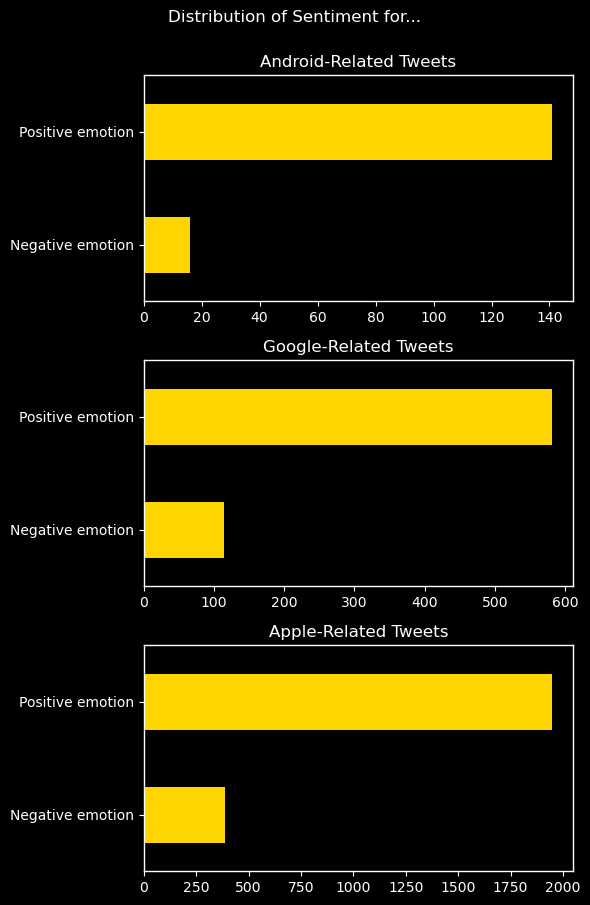

In [164]:
fig, ax = plt.subplots(nrows=3, figsize=(6, 9))

# Android plot
sentiment_counts_by_brand.loc[('Android',)].drop(
    ['No emotion toward brand or product'], axis=0
).plot(kind='barh', ax=ax[0])
ax[0].set_title('Android-Related Tweets')

# Google plot
sentiment_counts_by_brand.loc[('Google',)].drop(
    ['No emotion toward brand or product', "I can't tell"], axis=0
).plot(kind='barh', ax=ax[1])
ax[1].set_title('Google-Related Tweets')

# Apple plot
sentiment_counts_by_brand.loc[('Apple',)].drop(
    ['No emotion toward brand or product', "I can't tell"], axis=0
).plot(kind='barh', ax=ax[2])
ax[2].set_title('Apple-Related Tweets')

# don't label y-axis
for axis in ax:
    axis.set_ylabel('')
    
# avoid overlap of subplots
fig.suptitle('Distribution of Sentiment for...', y=1)
fig.tight_layout();

In [172]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [173]:
!git log --oneline

6642ec2 (HEAD -> main, origin/main, origin/HEAD) set up notebook environment and summarize data
687bb47 Broaden hyperparameter search with Amazon SageMaker notebook
ad863bc Refactor preprocessing code
900c8c7 Tune several model candidates
943cccf Reorganize preprocessing steps
9ff1241 More EDA
ab23639 Add eda step / brand breakdown
68b4479 Build a neural network; test different architectures
e76e83f Track negative recall score
87dbcf6 Make negative recall scorer
e00e38f Build stacked embedding
7ce8a6e Build custom word2vec model; try bag of words
f641e82 Plot confusion matrix; tune logistic regression; try random forest
4041f75 Test padding mean word vector
62aefa0 Preprocess data & set up for model tuning
0dc62d4 Ignore data
6e356bf Initial commit


## 2. Data Preparation
### 2.1 Part 1

Deal with null values.

In [8]:
# deal with null values
data.loc[data.tweet_text==None]

,tweet_text,object,sentiment,brand


In [9]:
data.dropna(subset=['tweet_text'], axis=0, inplace=True)

Split the data into train, validation and test sets.

In [10]:
X = data['tweet_text'].copy()
y = data['sentiment'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=seed, test_size=0.25)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5454,)
(1819,)
(1819,)


Label encode the target.

In [11]:
# label encoding
le = LabelEncoder()

y_train_encoded = pd.Series(le.fit_transform(y_train), index=y_train.index)

y_val_encoded = pd.Series(le.transform(y_val), index=y_val.index)
y_test_encoded = pd.Series(le.transform(y_test), index=y_test.index)

Remove stop words, strip punctuation, and stem or lemmatize tokens.

In [12]:
# remove stop words, strip punctuation, and stem or lemmatize tokens
stopwords_list = stopwords.words('english')
stopwords_list.extend(['rt', 'sxsw', 'mention', 'quot;s&quot', 'quot;x&quot', 'quot;w&quot', 'link', 'sxswi', "i'm"])

porter = PorterStemmer()

X_train_stemmed = X_train.map(lambda x: [porter.stem(
    w.lower().strip(string.punctuation).strip('quot;').strip('&quot')
) for w in x.split() if w.lower().strip(string.punctuation) not in stopwords_list])

X_train_stemmed.head()

5711    [fals, alarm, googl, circl, come, probabl, eve...
8483    [notic, ds, come, weekend, mani, iphon, ser, h...
7760    [said, abl, ge, ipad, 2, appl, pene, pop-up, s...
6315          [migh, need, g, appl, day, hink, key, worn]
3258                 [get, readi, listen, parti, podcast]
Name: tweet_text, dtype: object

In [13]:
X_val_stemmed = X_val.map(lambda x: [porter.stem(
    w.lower().strip(string.punctuation).strip('quot;').strip('&quot')
) for w in x.split() if w.lower().strip(string.punctuation) not in stopwords_list])

X_test_stemmed = X_test.map(lambda x: [porter.stem(
    w.lower().strip(string.punctuation).strip('quot;').strip('&quot')
) for w in x.split() if w.lower().strip(string.punctuation) not in stopwords_list])

## 1. Data Understanding
### 1.2 Part 2

Now that we have tokenized each tweet, we can build a frequency distribution for each sentiment category, for each brand. (It's possible that doing so will reveal additional stop words that ought to be removed, or some other pattern that can be captured in the data.)

To analyze the word distribution for each value of the target, we need a set of all training data with the labels included.

In [14]:
all_train = pd.concat([X_train_stemmed.map(lambda x: ' '.join(x)), y_train], axis=1)
all_train.head()

,tweet_text,sentiment
5711,fals alarm googl circl come probabl ever much...,Negative emotion
8483,notic ds come weekend mani iphon ser hour late...,Negative emotion
7760,said abl ge ipad 2 appl pene pop-up store austin,No emotion toward brand or product
6315,migh need g appl day hink key worn,No emotion toward brand or product
3258,get readi listen parti podcast,No emotion toward brand or product


Write a function to build a frequency distribution of the most common *n* words and display the results as a bar graph.

In [27]:
def display_fdist(data, n, normalize=False):
    '''Displays a bar graph representing the top n words in the data.'''
    fdist = FreqDist(' '.join(data.tolist()).split())
    top_n = {x[0]: x[1] for x in fdist.most_common(n)}
    raw = pd.Series(top_n)
    normalized = pd.Series(dict(zip(top_n.keys(), [x/fdist.N() for x in top_n.values()])))
    
    if normalize:
        graph_data = normalized
    else:
        graph_data = raw
    
    fig, ax = plt.subplots(figsize=(4, 4))
    
    sns.barplot(x=graph_data.values, y=graph_data.index);

Examine the most frequently occurring stems across the entire training data.

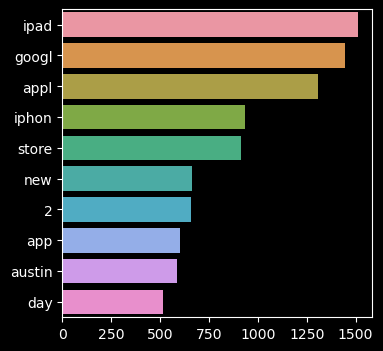

In [28]:
display_fdist(all_train.tweet_text, 10)

Normalizing the frequency distribution above suggests that, for modeling purposes, excluding words which occur more than 1% of the time would eliminate the top 10 words, and excluding words which occur more than 5% of the time would not eliminate any of the vocabulary.

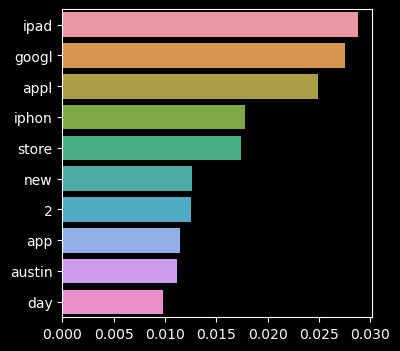

In [29]:
display_fdist(all_train.tweet_text, 10, normalize=True)

Examine the top 20 words in the frequency distribution for negative tweets.

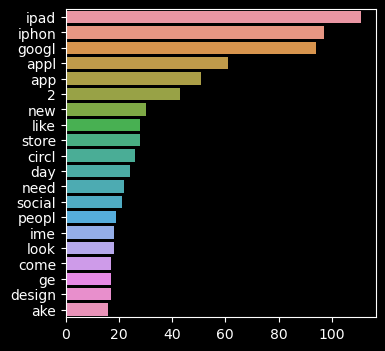

In [30]:
display_fdist(all_train.loc[all_train.sentiment=='Negative emotion', 'tweet_text'], 20)

Examine the top 20 words in the frequency distribution for positive tweets.

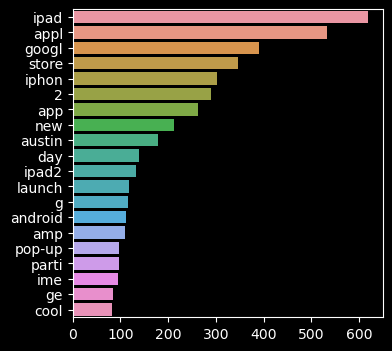

In [31]:
display_fdist(all_train.loc[all_train.sentiment=='Positive emotion', 'tweet_text'], 20)

Build a frequency distribution that includes bigrams (and possible trigrams.)

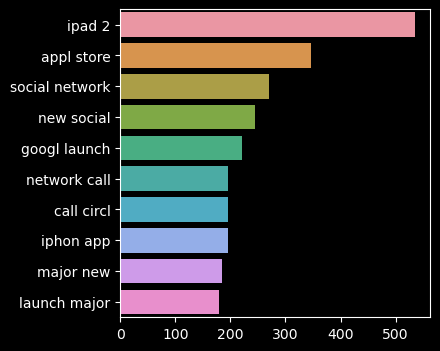

In [32]:
# build a frequency distribution that includes bigrams and possibly trigrams
top10 = FreqDist(nltk.bigrams(' '.join(all_train.tweet_text.tolist()).split())).most_common(10)
bigram_fdist = pd.Series({x[0][0] + ' ' + x[0][1]:x[1] for x in top10})

fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(x=bigram_fdist.values, y=bigram_fdist.index);

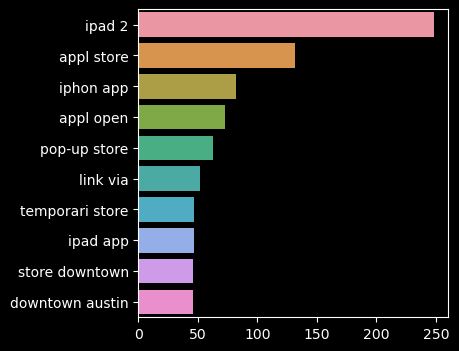

In [123]:
# build a frequency distribution for bigrams in POSITIVE tweets
top10 = FreqDist(nltk.bigrams(' '.join(
    all_train.loc[all_train.sentiment=='Positive emotion', 'tweet_text'].tolist()
).split())).most_common(10)
bigram_fdist = pd.Series({x[0][0] + ' ' + x[0][1]:x[1] for x in top10})

fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(x=bigram_fdist.values, y=bigram_fdist.index);

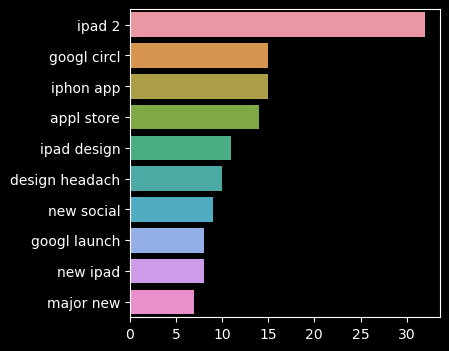

In [33]:
# build a frequency distribution for bigrams in NEGATIVE tweets
top10 = FreqDist(nltk.bigrams(' '.join(
    all_train.loc[all_train.sentiment=='Negative emotion', 'tweet_text'].tolist()
).split())).most_common(10)
bigram_fdist = pd.Series({x[0][0] + ' ' + x[0][1]:x[1] for x in top10})

fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(x=bigram_fdist.values, y=bigram_fdist.index);

In [130]:
!git log --oneline

2e021cf (HEAD -> main, origin/main, origin/HEAD) Clean text data and build frequency distributions
6642ec2 set up notebook environment and summarize data
687bb47 Broaden hyperparameter search with Amazon SageMaker notebook
ad863bc Refactor preprocessing code
900c8c7 Tune several model candidates
943cccf Reorganize preprocessing steps
9ff1241 More EDA
ab23639 Add eda step / brand breakdown
68b4479 Build a neural network; test different architectures
e76e83f Track negative recall score
87dbcf6 Make negative recall scorer
e00e38f Build stacked embedding
7ce8a6e Build custom word2vec model; try bag of words
f641e82 Plot confusion matrix; tune logistic regression; try random forest
4041f75 Test padding mean word vector
62aefa0 Preprocess data & set up for model tuning
0dc62d4 Ignore data
6e356bf Initial commit


## 1. Data Understanding
### 1.3 Topic Modeling

Include bigrams in our topic model.

In [38]:
bigrams = gensim.models.Phrases(X_train_stemmed.to_list()) # use default min count & threshold

bigram_model = gensim.models.phrases.Phraser(bigrams)

def make_bigrams(texts):
    return [bigram_model[doc] for doc in texts]

Get the corpus and dictionary to pass to gensim's LDA model.

In [39]:
texts = make_bigrams(X_train_stemmed.to_list())

id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

Build a baseline model.

In [41]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=5,
                                            random_state=seed,
                                            chunksize=500,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True) #remove if not used

Print model metrics, perplexity and coherence score.

In [42]:
print(f'Perplexity: {lda_model.log_perplexity(corpus)}')

coherence_model = CoherenceModel(model=lda_model,
                                 texts=texts,
                                 dictionary=id2word,
                                 coherence='c_v')
print(f'Coherence score: {coherence_model.get_coherence()}')

Perplexity: -7.773215848325229
Coherence score: 0.3703002361826105


Visualize the topics.

In [51]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.280583  0.020862       1        1  42.110283
3     -0.099974 -0.270909       2        1  20.388307
2      0.069629  0.067727       3        1  15.641515
1     -0.055338 -0.015180       4        1  11.995439
4     -0.194901  0.197501       5        1   9.864456, topic_info=             Term         Freq        Total Category  logprob  loglift
27           appl   999.000000   999.000000  Default  30.0000  30.0000
4           googl  1037.000000  1037.000000  Default  29.0000  29.0000
203         store   395.000000   395.000000  Default  28.0000  28.0000
22         austin   415.000000   415.000000  Default  27.0000  27.0000
75   googl_launch   169.000000   169.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
110             2    19.945226    92.505212   Topic5  -5.4509   0.7820
51          mobil    19.469598   156.199975   Topic5  -5.4751   0.2339
702         futur    15.964036    48.885756   Topic5  -5.6736   1.1971
711        design    15.719614    86.908073   Topic5  -5.6890   0.6063
137          ipad    15.132671   808.107483   Topic5  -5.7271  -1.6616

[256 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
246       3  0.994082     1
110       1  0.140533     2
110       2  0.291875     2
110       3  0.248635     2
110       4  0.097292     2
...     ...       ...   ...
873       2  0.115647  year
873       3  0.115647  year
873       4  0.424038  year
873       5  0.366214  year
195       5  0.949553   ÷¼

[283 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2, 5])

Choose the optimal number of topics based on coherence score.

In [56]:
def optimize_num_topics(dictionary, corpus, texts, start=2, stop=30):
    '''Determine the coherence value for LDA models with start to stop number of topics, by 2s.'''
    coherence_values = []
    model_candidates = []
    for num_topics in range(start, stop + 2, 2):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=seed,
                                                    chunksize=500, passes=10, alpha='auto')
        model_candidates.append(lda_model)
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return model_candidates, coherence_values

In [58]:
%%time

model_candidates, coherence_values = optimize_num_topics(id2word, corpus, texts)

print(max(coherence_values))

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/gensim/models/ldamodel.py:141: RuntimeWarning: divide by zero encountered in true_divide
  b = np.sum(gradf / q) / (1 / c + np.sum(1 / q))


0.5238120561003934
CPU times: user 3min 14s, sys: 48.4 ms, total: 3min 14s
Wall time: 3min 16s


Look for patterns in the coherence score as a function of the number of topics:

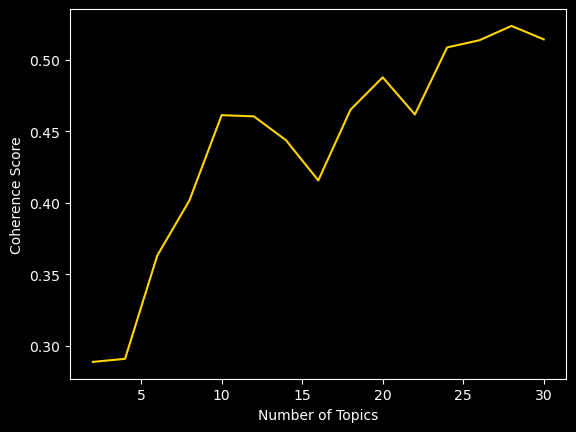

In [60]:
fig, ax = plt.subplots()

sns.lineplot(x=list(range(2, 32, 2)), y=coherence_values)
ax.set_ylabel('Coherence Score')
ax.set_xlabel('Number of Topics');

Increase the range of topics.

In [61]:
%%time

model_candidates, coherence_values = optimize_num_topics(id2word, corpus, texts, start=10, stop=50)

print(max(coherence_values))

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/gensim/models/ldamodel.py:141: RuntimeWarning: divide by zero encountered in true_divide
  b = np.sum(gradf / q) / (1 / c + np.sum(1 / q))


0.5329538219528486
CPU times: user 5min 24s, sys: 67.6 ms, total: 5min 24s
Wall time: 5min 28s


Check pattern(s) in the coherence score as a function of the number of topics:

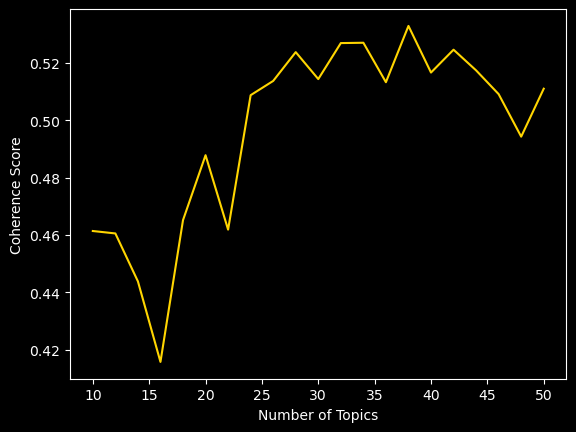

In [63]:
fig, ax = plt.subplots()

sns.lineplot(x=list(range(10, 52, 2)), y=coherence_values)
ax.set_ylabel('Coherence Score')
ax.set_xlabel('Number of Topics');

The coherence scores of our models generally increase until 28 topics, then "level off" and ultimately decrease. Get the index and score of our "best" model with 28 topics.

In [73]:
[model.num_topics for model in model_candidates].index(28)

9

In [71]:
coherence_values[9]

0.5238120561003934

We determine the same "best" number of topics from either experiment (28 topics.)

Build a model with 28 topics.

In [74]:
best_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                 id2word=id2word,
                                                 num_topics=28,
                                                 random_state=seed,
                                                 chunksize=500,
                                                 passes=10,
                                                 alpha='auto',
                                                 per_word_topics=True) #remove if not used

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/gensim/models/ldamodel.py:141: RuntimeWarning: divide by zero encountered in true_divide
  b = np.sum(gradf / q) / (1 / c + np.sum(1 / q))


Visualize the results.

In [75]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(best_lda_model, corpus, id2word)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
21     0.219774  0.251051       1        1  8.664773
19    -0.066402  0.038072       2        1  7.356765
10    -0.241102  0.166746       3        1  6.085840
26    -0.264615  0.140142       4        1  5.479201
13     0.043478  0.022567       5        1  4.611202
27    -0.024901  0.093598       6        1  4.316089
0      0.084990  0.032318       7        1  4.013857
2      0.017189  0.134776       8        1  3.997445
7      0.074279  0.033772       9        1  3.855885
1     -0.157407 -0.029643      10        1  3.724284
9     -0.019067  0.038201      11        1  3.482414
24     0.115794  0.085446      12        1  3.469817
18     0.082247  0.040324      13        1  3.268523
11    -0.007685 -0.084860      14        1  3.188199
14    -0.075796 -0.048573      15        1  3.150119
12     0.033090 -0.054816      16        1  3.042891
4      0.022477 -0.086811      17        1  2.987087
23    -0.030327 -0.101238      18        1  2.885412
17     0.106799 -0.005571      19        1  2.793320
5      0.099488  0.012743      20        1  2.786302
22    -0.156527 -0.012226      21        1  2.712749
25     0.042815 -0.035682      22        1  2.477641
3      0.099138 -0.022512      23        1  2.472373
16     0.004516 -0.121141      24        1  2.207520
20     0.013041 -0.117052      25        1  2.030314
8      0.010257 -0.133871      26        1  1.902998
6     -0.040162 -0.103987      27        1  1.573265
15     0.014618 -0.131773      28        1  1.463713, topic_info=           Term         Freq        Total Category  logprob  loglift
4         googl  1407.000000  1407.000000  Default  30.0000  30.0000
27         appl  1346.000000  1346.000000  Default  29.0000  29.0000
203       store   531.000000   531.000000  Default  28.0000  28.0000
22       austin   575.000000   575.000000  Default  27.0000  27.0000
88          app   550.000000   550.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1362  eam_start     4.565375     5.666101  Topic28  -5.0175   4.0082
1366       audi     3.922975     5.023701  Topic28  -5.1691   3.9769
1220   radeshow     3.523644     4.624370  Topic28  -5.2765   3.9523
942         car     7.185434    10.469296  Topic28  -4.5639   3.8478
990        work     4.006405   100.264255  Topic28  -5.1481   1.0043

[1006 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
1518      1  0.866004             -shir
1027     26  0.905719  03/12/11_infektd
246      11  0.984351                 1
106      11  0.975657                10
1028     24  0.886043    12:00-3:59:59p
...     ...       ...               ...
195      17  0.956729               ÷¼
109       1  0.912747       ûï@mention
109      11  0.047049       ûï@mention
109      21  0.037639       ûï@mention
1060     10  0.854592               ûò

[1038 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[22, 20, 11, 27, 14, 28, 1, 3, 8, 2, 10, 25, 19, 12, 15, 13, 5, 24, 18, 6, 23, 26, 4, 17, 21, 9, 7, 16])

In [134]:
len(words_per_topic)

28

In [102]:
X_train_stemmed.shape[0]

5454

In [101]:
len(corpus)

5454

Find the documents containing a topic *i*. Then find the document with the highest percentage of the topic in question.

In [119]:
topics_per_doc = [best_lda_model.get_document_topics(tweet) for tweet in corpus]
most_representative_tweets = []

for i in range(best_lda_model.num_topics):
    contribution_to_topic = []
    for doc in topics_per_doc:
        if i in [x[0] for x in doc]:
            location = [x[0] for x in doc].index(i)
            contribution_to_topic.append(doc[location][1])
        else:
            contribution_to_topic.append(0)
    most_representative_tweets.append(np.argmax(contribution_to_topic))

Create a list of the words that contribute to each topic.

In [132]:
words_per_topic = []

for list_of_topic_terms in [best_lda_model.get_topic_terms(i) for i in range(best_lda_model.num_topics)]:
    words_in_topic = []
    for word, perc in list_of_topic_terms:
        words_in_topic.append(id2word[word])
    words_per_topic.append(words_in_topic)

Compare topic "summary" (i.e. list of words contributing to the topic) to most representative tweet.

In [141]:
pd.concat([pd.DataFrame({'topic': words_per_topic}, index=X_train.iloc[most_representative_tweets].index),
           X_train.iloc[most_representative_tweets]], axis=1)

,topic,tweet_text
4353,"[iphon, work, google', futur, witter, friend, ...","Google's Mobile Future, and the Elusive 'Power..."
7106,"[via, ipad_2, launch, year, keep, downtown_aus...",Apple is opening up a temporary store in downt...
6675,"[amp, iphon, game, play, 4, ipad_2, day, hour,...",RT @mention Sound of My Voice was shot exploit...
6563,"[awesom, ipad, case, cool, foursquar, enjoy, a...",RT @mention RT @mention If you were able to af...
7685,"[mobil, ser, wan, marissa_mayer, realli, h, in...",#SXSW: Marissa Mayer keynote- 40% Of Google Ma...
5037,"[make, know, locat, present, android, pick, ac...",RT @mention : Aron Pilhofer from The New York ...
7563,"[be, head, congress, wow, walk, fail, room, in...","Congrats Radical Media, Google, Arcade Fire fo..."
5678,"[free, look, music, ipad, righ, itun, produc, ...",RT @mention Diller: Why would you do product o...
2889,"[would, attend, side, everi, mean, minut, devi...",Goal funnels in Google Analytics to track regi...
918,"[iphon_app, fir, 1, panel, week, store_includ,...",ÛÏ@mention New #UberSocial for #iPhone now in...


Too many topics to analyze - try seven topics, based on overlapping topic circles in visualization.

In [34]:
smaller_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=7,
                                                    random_state=seed,
                                                    chunksize=500,
                                                    passes=10,
                                                    alpha='auto',
                                                    per_word_topics=True)

NameError: name 'corpus' is not defined

Create a corpus and dictionary for each "set" of tweets (positive, negative, neutral and Apple-specific.)

Write a function to optimize the number of topics (based on coherence score) for a given corpus and dictionary. Have the function print the best coherence score and return the best model.

Visualize topics with pyLDAvis.

Order topics by score (of semantic similarity) and examine the top 5, including the "most representative tweet" for each topic.

Get a set of all positive, negative and neutral tweets in the training data. Additionally, find all tweets directed toward Apple in the training dataset.

In [27]:
all_train = pd.concat([X_train_stemmed, y_train], axis=1)

negative_tweets = all_train.loc[all_train.sentiment=='Negative emotion', 'tweet_text'].copy()
positive_tweets = all_train.loc[all_train.sentiment=='Positive emotion', 'tweet_text'].copy()
neutral_tweets = all_train.loc[all_train.sentiment=='No emotion toward brand or product', 'tweet_text'].copy()

apple_index = data.loc[X_train.index].loc[data.brand=='Apple', 'tweet_text'].index
apple_tweets = X_train_stemmed.loc[apple_index]

Next, generate a corpus and dictionary for each set.

In [32]:
def get_corpus_and_dict(documents):
    '''Given a set of tweets (documents), returns the corpus, dictionary and texts required to train gensim's LDA
    model.'''
    # generate bigrams
    bigrams = gensim.models.Phrases(documents.to_list()) # use default min count & threshold
    bigram_model = gensim.models.phrases.Phraser(bigrams)

    def make_bigrams(texts):
        return [bigram_model[doc] for doc in texts]

    texts = make_bigrams(documents.to_list())

    id2word = corpora.Dictionary(texts)
    corpus = [id2word.doc2bow(text) for text in texts]
    
    return corpus, id2word, texts

Select the best fitting LDA model based on the model's coherence score.

In [33]:
def select_best_lda(dictionary, corpus, texts, start=2, stop=20):
    '''Use the coherence values for LDA models with start to stop number of topics, by 2s, to determine and return
    the best LDA model for this dictionary and corpus with these texts.'''
    coherence_values = []
    model_candidates = []
    for num_topics in range(start, stop + 2, 2):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                                                    random_state=seed, chunksize=500, passes=10, alpha='auto')
        model_candidates.append(lda_model)
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        
    print(f'Coherence score for best model: {max(coherence_values)}')
    
    return model_candidates[np.argmax(coherence_values)]

In [ ]:
tweet_categories = [positive_tweets, negative_tweets, neutral_tweets, apple_tweets]

for category in tweet_categories:
    
    corpus, id2word, texts = get_corpus_and_dict(category)

    best_lda_model = select_best_lda(id2word, corpus, texts)
    
    

In [229]:
def topic_model_summary(tweets):
    '''Given a series of tweets, returns a wordcloud and the most representative tweet
    for each of the top 5 most "coherent" topics produced by the best LDA topic model
    found.
    
    Returns:
    wc - wordcloud object
    lda - best lda model
    summary_tweets - most representative tweet for each topic'''
    
    global X_train
    
    corpus, id2word, texts = get_corpus_and_dict(tweets)

    best_lda_model = select_best_lda(id2word, corpus, texts)
    
    if best_lda_model.num_topics < 5:
        num_topics = best_lda_model.num_topics
    else:
        num_topics = 5
    
    top_topics = most_interpretable_topics(best_lda_model, n=num_topics)
    
    # get the "most representative" tweet for each topic
    most_representative_tweets = []
    document_topics = [best_lda_model.get_document_topics(tweet) for tweet in corpus]

    for topic in top_topics:
        contribution_to_topic = []

        for doc in document_topics:
            if topic in [topic for topic, percentage in doc]:
                location = [topic for topic, percentage in doc].index(topic)
                contribution_to_topic.append(doc[location][1])
            else:
                contribution_to_topic.append(0)
        most_representative_tweets.append(np.argmax(contribution_to_topic))
        
    summary_tweets = [X_train.loc[tweets.index[i]] for i in most_representative_tweets]

    # build a word cloud for each of the top topics
    word_clouds = []
    
    for topic_index, tweet in zip(top_topics, summary_tweets):
    
        wordcloud_text = []

        for w, f in best_lda_model.show_topic(topic_index):
            wordcloud_text.extend([w]*int(100*f))
            
        wc = WordCloud(max_words=len(words), relative_scaling=1, collocations=False).generate(' '.join(wordcloud_text))
        word_clouds.append(wc)
        
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show();
        
        print(tweet)
        
    return word_clouds, summary_tweets

Coherence score for best model: 0.4576159282791464


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


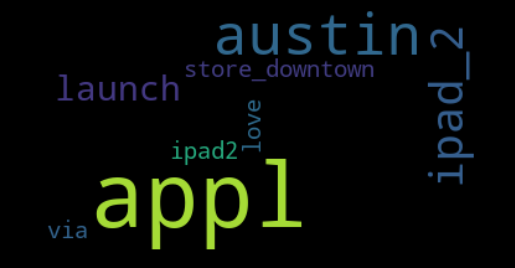

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Love the Apple pop-up store at #SXSW. So freaking smart. Now, one question. Will AT&amp;T bring trucks for signal again? Please say yes.


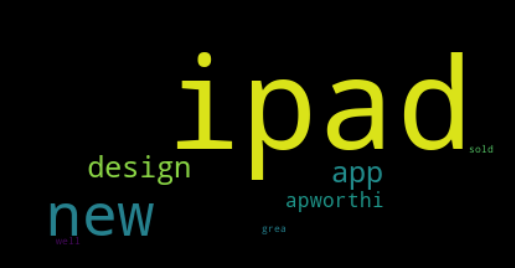

Vinh: Flipboard is a step forward for iPad mags, those that get it right will go down this path - not the Wired path #sxsw


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


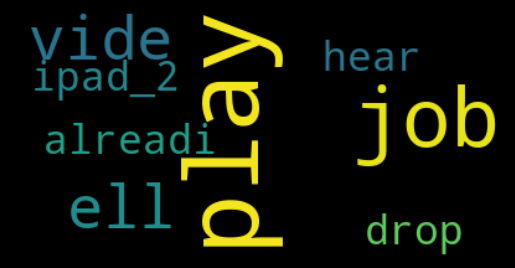

Can already tell i should have brought as ass pillow and iPhone backup charger to #sxsw #numbassonfloor


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


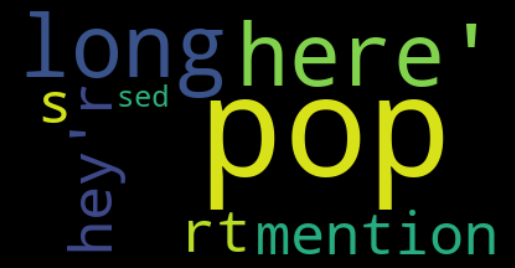

Wow. Shakespeare's Pub on 6th St. Here's to the delete button on the iPhone video camera. #SXSW


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


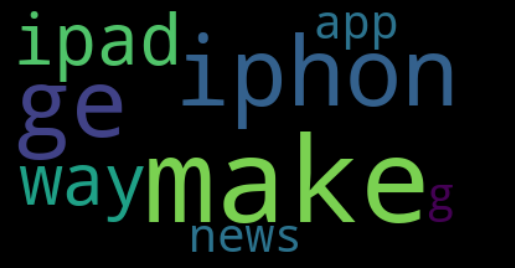

I'm headed down to #SXSW to hear a talk on integrated social network dynamics and team synergy.  I've got my iPad ready to go.


([<wordcloud.wordcloud.WordCloud at 0x7f7d0b323850>,
 ['Love the Apple pop-up store at #SXSW. So freaking smart. Now, one question. Will AT&amp;T bring trucks for signal again? Please say yes.',
  'Vinh: Flipboard is a step forward for iPad mags, those that get it right will go down this path - not the Wired path #sxsw',
  'Can already tell i should have brought as ass pillow and iPhone backup charger to #sxsw #numbassonfloor',
  "Wow. Shakespeare's Pub on 6th St. Here's to the delete button on the iPhone video camera. #SXSW",
  "I'm headed down to #SXSW to hear a talk on integrated social network dynamics and team synergy.  I've got my iPad ready to go."])

In [227]:
topic_model_summary(apple_tweets)

Coherence score for best model: 0.4524414642333764


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


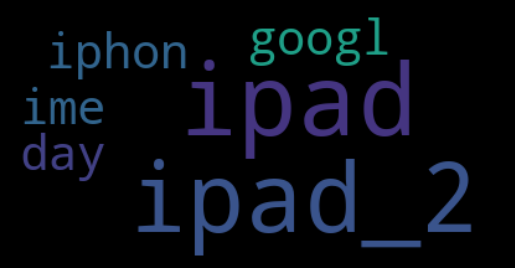

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Trying to balance the power of power needs on iPhone vs iPad at #sxsw. This 3G iPad sucks it out quick. Might have go airplane mode.


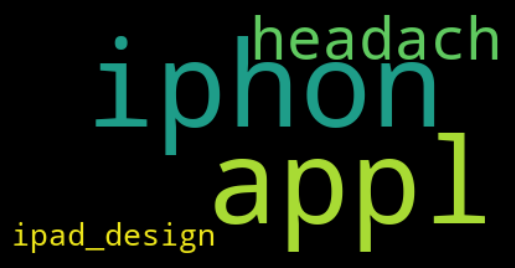

RT @mention Google hotpot- rate restaurants and get personalized recos on where to eat. Um, think foursquare, yelp, etc have this covered already. #SXSW


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


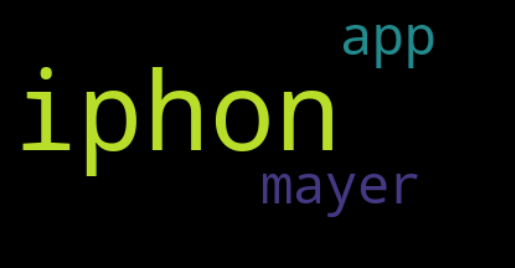

Length of Google penalty based on severity of breach of webmaster guidelines. i.e.white text on white bgr might get 30 day pen. #sxsw #qagb


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


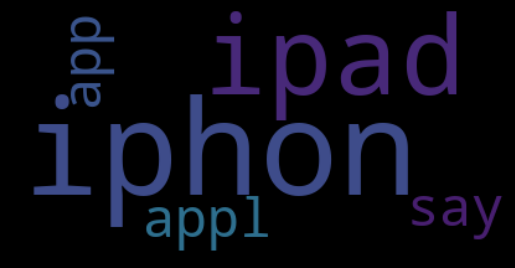

line around the corner for #iPad2 at #sxsw, i say wait on it. I've already got two cameras on my #iPhone sorry #apple


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


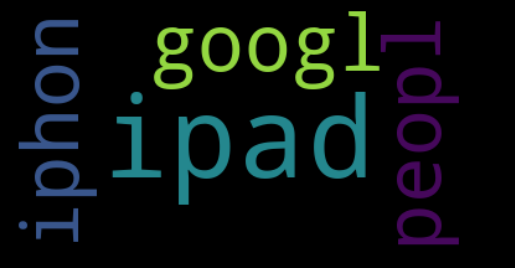

RT @mention Google vs Bing on #bettersearch. Bing has a shot at success w/ structured search.  Potentially higher margin CPA model vs #Google. #SXSW


([<wordcloud.wordcloud.WordCloud at 0x7f7d0b02b1c0>,
 ['Trying to balance the power of power needs on iPhone vs iPad at #sxsw. This 3G iPad sucks it out quick. Might have go airplane mode.',
  'RT @mention Google hotpot- rate restaurants and get personalized recos on where to eat. Um, think foursquare, yelp, etc have this covered already. #SXSW',
  'Length of Google penalty based on severity of breach of webmaster guidelines. i.e.white text on white bgr might get 30 day pen. #sxsw #qagb',
  "line around the corner for #iPad2 at #sxsw, i say wait on it. I've already got two cameras on my #iPhone sorry #apple",
  'RT @mention Google vs Bing on #bettersearch. Bing has a shot at success w/ structured search.  Potentially higher margin CPA model vs #Google. #SXSW'])

In [230]:
topic_model_summary(negative_tweets)

Coherence score for best model: 0.4605837163092613


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


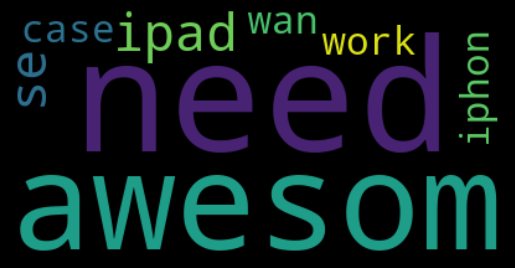

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


@mention Yes, that's why I favorited it! I want to win. I need to win. doo dah doo dah. :D #pushio #sxsw #ipad


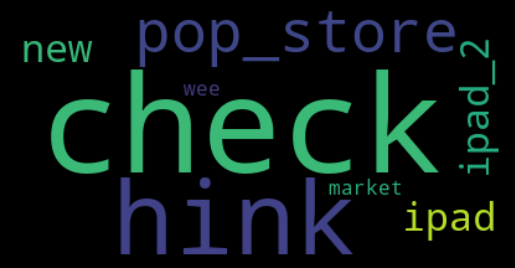

On the Early #nerdbird to #SXSW - get @mention iPhone app. Share photos of airport people. Like people of Wal-Mart, but at airports!


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


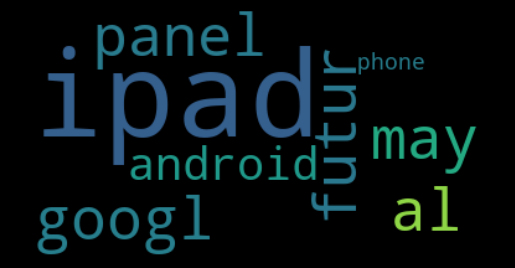

RT @mention deviantART buys 3 iPad 2's in Austin, tests Muro drawing, it's super fast!! #deviantART #SXSW {link}


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


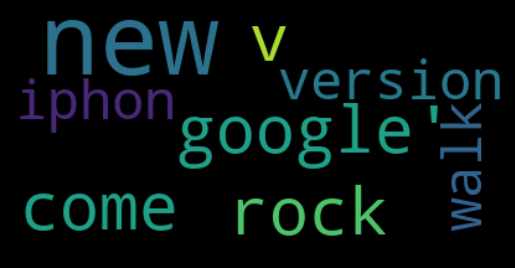

RT @mention Awesome new version of @mention for iPhone &amp; new web site coming after #sxsw. Want a demo? Meet with @mention at #sxsw.


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


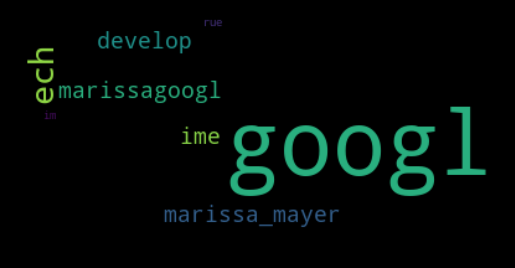

RT @mention When brand focuses on purpose, not object, they survive &amp; succeed. Google: not search, useful info. Nike: not sneakers, performance. #sxsw


([<wordcloud.wordcloud.WordCloud at 0x7f7d14d45900>,
 ["@mention Yes, that's why I favorited it! I want to win. I need to win. doo dah doo dah. :D #pushio #sxsw #ipad",
  'On the Early #nerdbird to #SXSW - get @mention iPhone app. Share photos of airport people. Like people of Wal-Mart, but at airports!',
  "RT @mention deviantART buys 3 iPad 2's in Austin, tests Muro drawing, it's super fast!! #deviantART #SXSW {link}",
  'RT @mention Awesome new version of @mention for iPhone &amp; new web site coming after #sxsw. Want a demo? Meet with @mention at #sxsw.',
  'RT @mention When brand focuses on purpose, not object, they survive &amp; succeed. Google: not search, useful info. Nike: not sneakers, performance. #sxsw'])

In [231]:
topic_model_summary(positive_tweets)

Coherence score for best model: 0.49062957143504293


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


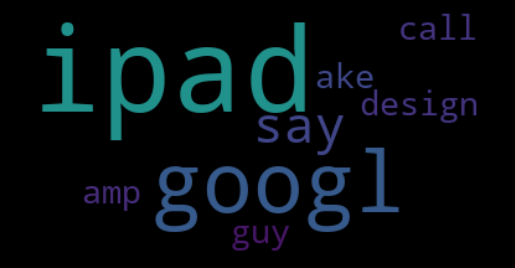

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Lack of collaboration &amp; opportunism RT @mention Why has latin America not produced the next @mention or @mention ? #Latism #latam #sxsw


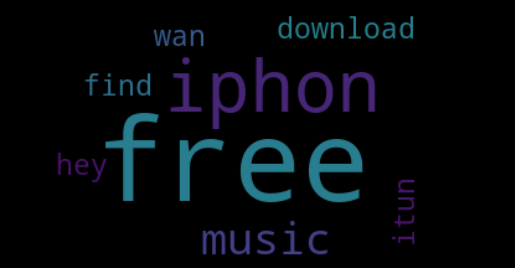

RT #LOVE&lt;=&gt; Hey Austin, know a little about #iPhone or #Android, love music &amp; wanna make $20/hour during #SXSW? Please let me know.: Hey...


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


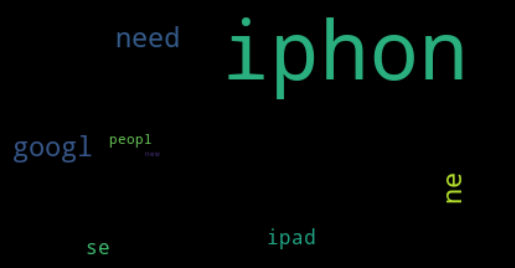

il CEO di flipboard annuncia la versione iPhone ÛÏ@mention @mention next platform for Flipboard is the iPhone Team started working on it #SXSW


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


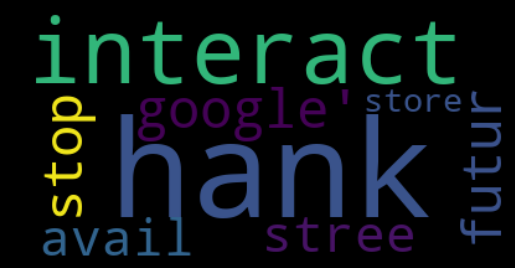

RT @mention Download 20+ FREE tracks from the #SXSW Music Sampler available on the @mention store today!  {link} #dtsxsw #fb


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


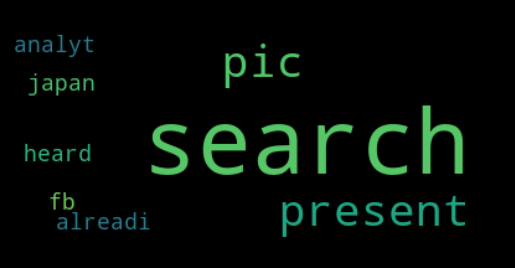

Goal funnels in Google Analytics to track registrations. #srsly #sxsw #mitharvard


([<wordcloud.wordcloud.WordCloud at 0x7f7d0b32a770>,
 ['Lack of collaboration &amp; opportunism RT @mention Why has latin America not produced the next @mention or @mention ? #Latism #latam #sxsw',
  'RT #LOVE&lt;=&gt; Hey Austin, know a little about #iPhone or #Android, love music &amp; wanna make $20/hour during #SXSW? Please let me know.: Hey...',
  'il CEO di flipboard annuncia la versione iPhone \x89ÛÏ@mention @mention next platform for Flipboard is the iPhone Team started working on it #SXSW',
  'RT @mention Download 20+ FREE tracks from the #SXSW Music Sampler available on the @mention store today!  {link} #dtsxsw #fb',
  'Goal funnels in Google Analytics to track registrations. #srsly #sxsw #mitharvard'])

In [232]:
topic_model_summary(neutral_tweets)

Run through on individual example:

In [35]:
corpus, id2word, texts = get_corpus_and_dict(apple_tweets)

best_lda_model = select_best_lda(id2word, corpus, texts)

Coherence score for best model: 0.4576159282791464


In [216]:
def topic_index(best_lda_model):
    '''Returns an "index" of topics described by word distributions.'''

    index_of_topic_reps = []

    for topic_rep in [topic_rep for index, topic_rep in best_lda_model.print_topics(num_words=8)]:
        pieces = [item\
                  for sublist in [phrase.split('+') for phrase in topic_rep.split('*')]\
                  for item in sublist]
        clean_pieces = [x.strip('\"').strip().strip('\"') for x in pieces]

        percentages = [float(piece) for piece in clean_pieces if clean_pieces.index(piece) % 2 == 0]
        words = [piece for piece in clean_pieces if clean_pieces.index(piece) % 2 == 1]

        clean_topic_rep = [(percent, word) for percent, word in zip(percentages, words)]

        index_of_topic_reps.append(clean_topic_rep)
        
    return index_of_topic_reps

In [218]:
def most_interpretable_topics(best_lda_model, n=5):
    
    index_of_topic_reps = topic_index(best_lda_model)

    top_n_topics = []

    for top_topic in best_lda_model.top_topics(texts=texts, dictionary=id2word, coherence='c_v', topn=8)[:n]:
        to_match = [(round(float(percent), 3), word) for percent, word in top_topic[0]]
        top_n_topics.append(index_of_topic_reps.index(to_match))

    return top_n_topics

In [209]:
[best_lda_model.show_topic(i) for i in top_5_topics][0]

[('appl', 0.08661478),
 ('austin', 0.054877445),
 ('ipad_2', 0.046606004),
 ('launch', 0.036552552),
 ('love', 0.028067993),
 ('ipad2', 0.02564217),
 ('via', 0.024508355),
 ('store_downtown', 0.021776162),
 ('come_cool', 0.021147532),
 ('g_confer', 0.018382814)]

In [210]:
wordcloud_text = []

for w, f in [best_lda_model.show_topic(i) for i in top_5_topics][0]:
    wordcloud_text.extend([w]*int(100*f))

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


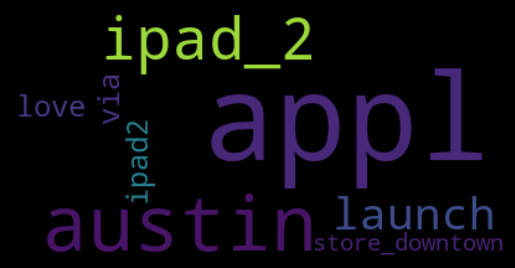

In [211]:
wc = WordCloud(max_words=len(words), relative_scaling=1, collocations=False).generate(' '.join(wordcloud_text))

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show();

---

In [60]:
top_5_topics = [x[0] for x in best_lda_model.print_topics(5, 8)]
topic_descriptions = [x[1] for x in best_lda_model.print_topics(5, 8)]

In [132]:
for i in range(len(topic_descriptions)):
    pieces = [item\
              for sublist in [phrase.split('+') for phrase in topic_descriptions[i].split('*')]\
              for item in sublist]
    clean_pieces = [x.strip('\"').strip().strip('\"') for x in pieces]
    
    percentages = [float(piece) for piece in clean_pieces if clean_pieces.index(piece) % 2 == 0]
    words = [piece for piece in clean_pieces if clean_pieces.index(piece) % 2 == 1]

['0.056', 'play', '0.041', 'job', '0.037', 'ell', '0.030', 'vide', '0.029', 'drop', '0.029', 'hear', '0.027', 'ipad_2', '0.022', 'alreadi']
[0.056, 0.041, 0.037, 0.03, 0.029, 0.029, 0.027, 0.022]
['play', 'job', 'ell', 'vide', 'drop', 'hear', 'ipad_2', 'alreadi']
['0.096', 'peopl', '0.037', 'hink', '0.036', 'photo', '0.024', 'space', '0.023', 'share', '0.020', 'film', '0.020', 'iphon_app', '0.019', 'ake']
[0.096, 0.037, 0.036, 0.024, 0.023, 0.02, 0.02, 0.019]
['peopl', 'hink', 'photo', 'space', 'share', 'film', 'iphon_app', 'ake']
['0.065', 'ipad', '0.050', 'iphon', '0.036', 'hank', '0.029', 'even', '0.026', 'awesom', '0.025', 'charg', '0.014', 'l', '0.014', 'amaz']
[0.065, 0.05, 0.036, 0.029, 0.026, 0.025, 0.014, 0.014]
['ipad', 'iphon', 'hank', 'even', 'awesom', 'charg', 'l', 'amaz']
['0.087', 'appl', '0.055', 'austin', '0.047', 'ipad_2', '0.037', 'launch', '0.028', 'love', '0.026', 'ipad2', '0.025', 'via', '0.022', 'store_downtown']
[0.087, 0.055, 0.047, 0.037, 0.028, 0.026, 0.025, 

In [75]:
pieces = [item for sublist in [phrase.split('+') for phrase in topic_descriptions[0].split('*')] for item in sublist]
pieces

['0.056',
 '"play" ',
 ' 0.041',
 '"job" ',
 ' 0.037',
 '"ell" ',
 ' 0.030',
 '"vide" ',
 ' 0.029',
 '"drop" ',
 ' 0.029',
 '"hear" ',
 ' 0.027',
 '"ipad_2" ',
 ' 0.022',
 '"alreadi"']

In [87]:
clean_pieces = [x.strip('\"').strip().strip('\"') for x in pieces]
clean_pieces

['0.056',
 'play',
 '0.041',
 'job',
 '0.037',
 'ell',
 '0.030',
 'vide',
 '0.029',
 'drop',
 '0.029',
 'hear',
 '0.027',
 'ipad_2',
 '0.022',
 'alreadi']

In [94]:
frequencies = [int(float(piece)*1000) for piece in clean_pieces if clean_pieces.index(piece) % 2 == 0]
frequencies

[56, 41, 37, 30, 29, 29, 27, 22]

In [90]:
words = [piece for piece in clean_pieces if clean_pieces.index(piece) % 2 == 1]
words

['play', 'job', 'ell', 'vide', 'drop', 'hear', 'ipad_2', 'alreadi']

In [91]:
%pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 kB 21.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [92]:
from wordcloud import WordCloud

In [97]:
wordcloud_text = []

for f, w in zip(frequencies, words):
    wordcloud_text.extend([w]*int(f))
    
print(len(wordcloud_text))
print(np.sum(frequencies))
wordcloud_text[:5]

271
271


['play', 'play', 'play', 'play', 'play']

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


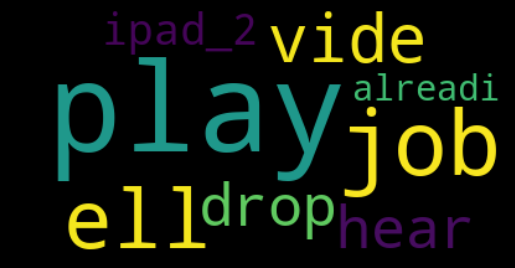

In [103]:
wc = WordCloud(max_words=len(words), relative_scaling=1, collocations=False).generate(' '.join(wordcloud_text))

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show();

Research: what do "ell" and "vide" represent? (Probably "tell" and "video", though there may be some "false matches" on other words as well.)

In [110]:
data.loc[X_train_stemmed.explode().loc[X_train_stemmed.explode()=='ell'].index, 'tweet_text']

7538    Hipster or hobo? Only way to tell is the iPhon...
7592    Google Circles.  Big rumor from what I can tel...
4417    RT@mention Crowley and Cashmore think iPad 2 i...
2584    Can already tell i should have brought as ass ...
8378    @mention tell @mention to give out gummy worms...
3754    Just ran into @mention and apparently @mention...
541     Austin is getting full, and #SXSW is underway....
4493    Crowley and Cashmore think iPad 2 is a minor s...
7201    #SXSW a tougher crowd than Colin Quinn RT @men...
8379    @mention Tell your #sxsw friends to send iRepo...
943     Continuum of attitudes on crowdsourcing: Gap i...
4561    Ok. Someone's trying to tell me something: For...
603     Less than half an hour and we'll tell you how ...
5694    RT @mention Dudes! Dudes! Check it out: Tweet ...
2818    Apple cited as the opposite of crowdsourcing -...
2952    #sxsw: @mention intrvw @mention &quot;Schmidt ...
2952    #sxsw: @mention intrvw @mention &quot;Schmidt ...
6109    RT @me

In [122]:
data.loc[X_train_stemmed.explode().loc[X_train_stemmed.explode()=='vide'].index, 'tweet_text'].sample(5)

1123    .@mention Team Android at #SXSW party details ...
8931    Video shows a guy hacking Times Sq billboards ...
2273    (-: Mashable! - The iPad 2 Takes Over SXSW [VI...
7463    Updated NPR Music iPhone app has song info for...
43      Mashable! - The iPad 2 Takes Over SXSW [VIDEO]...
Name: tweet_text, dtype: object

Find the most representative tweet for each of the top 5 topics.

In [61]:
document_topics = [best_lda_model.get_document_topics(tweet) for tweet in corpus]
most_representative_tweets = []

for topic in top_5_topics:
    contribution_to_topic = []
    
    for doc in document_topics:
        if topic in [topic for topic, percentage in doc]:
            location = [topic for topic, percentage in doc].index(topic)
            contribution_to_topic.append(doc[location][1])
        else:
            contribution_to_topic.append(0)
    most_representative_tweets.append(np.argmax(contribution_to_topic))

In [121]:
for i in most_representative_tweets:
    print(X_train.loc[apple_tweets.index[i]])

Can already tell i should have brought as ass pillow and iPhone backup charger to #sxsw #numbassonfloor
On the Early #nerdbird to #SXSW - get @mention iPhone app. Share photos of airport people. Like people of Wal-Mart, but at airports!
RT @mention deviantART buys 3 iPad 2's in Austin, tests Muro drawing, it's super fast!! #deviantART #SXSW httÛ_ (cont) {link}
Love the Apple pop-up store at #SXSW. So freaking smart. Now, one question. Will AT&amp;T bring trucks for signal again? Please say yes.
RT @mention In my next life I'm coming back as an iPad 2. Women can't keep their hands off this thing. #SXSW


## 3. Modeling
### 3.1 Selecting a Vectorizer and Optimizing Hyperparameters for Each Classification Algorithm

Use pipelines to test different vectorization techniques with different classification algorithms.

<u>Vectorizers</u>
- Count vectorization: ngram range, min / max df, max vocab
- "One hot" vectorization
- Tfidf vectorization: same as count vectorizer settings
- Mean word embeddings (using gensim's pretrained word2vec model)

<u>Classifiers</u>
- Decision Tree
- Nearest Neighbors
- Support Vector Classifier
- Naive Bayes
- Random Forest
- XGBoost (other library)

Use grid search and cross validation to find the optimal vectorization and hyperparameter settings for each classification algorithm.

## 4. Evaluation
### 4.1 Analyze Model Performance on Validation Set

In this section, the best model(s) so far are evaluated on the validation set after being trained on the training set. Insights from the model's performance on the validation set may be used to adjust preprocessing techniques and model hyperparameters.

Train the best model(s) on the training set, and analyze the performance of each model on the validation set using:

- overall accuracy (visualize: raw numbers confusion matrix)

- recall for each class (visualize: confusion matrix with normalize='true')

- both of the above for Apple-related tweets specifically (and perhaps each brand)

- grade_model_confidence function (displays bar chart with mean model accuracy as a function of model confidence in predicted class)

- use LIME to investigate most negative & positive tweets, or "most confident" mistakes (incorrect predictions for which the model was most confident)

- examine feature importances for the model

## 3. Modeling
### 3.2 Adjust Preprocessing Techniques and Model Hyperparameters

Based on evaluation of candidate models on the validation set, consider tweaking preprocessing techniques (esp. vectorization) and model hyperparameters.

## 4. Evaluation
### 4.2 Final Model Evaluation on Hold-out Test Set

In this section, the single best model is evaluated on the hold-out test set to approximate model performance on unseen data. Model analytics are used to determine whether the model is worthy for deployment.

Evaluate the best model's performance on the hold-out test set.

Analyze model mistakes, grade model confidence & find most positive and negative tweets about Apple specifically.

## 5. Modeling
### 5.1 Topic Modeling for Each Brand and Sentiment Category (using LDA)

If time permits, latent dirichlet allocation is used to perform topic modeling for each brand / sentiment category combination in the dataset.

The goal is to generate a visualization to allow the Apple marketing team to quickly understand which "topics" related to Apple and its competitors were viewed positively or negatively (or received the most attention) during South by Southwest this year.

Determine the optimal number of topics for each sentiment category for Apple:

Determine the topics and their weights via clustering:

Visualize the topics:

## 6. Evaluation
### 6.1 Evaluate Topic Models

Compute the perplexity and coherence score for the best model.

## 7. Recommendations
### 7.1 Recommendations for Apple's Next SXSW Campaign

Based on confidence scores generated by classifier:

Based on topic modeling for each brand / sentiment combination:

## 8. Conclusion

<u>Possible Next Steps</u>

-
-

<u>Further Reading</u>

A summary of the results from this analysis can be found in [this presentation]().

Learn more about South by Southwest [here](https://www.sxsw.com/).